In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from skimage.feature import local_binary_pattern
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay



In [3]:
path = "/content/drive/MyDrive/CPPSMS/EuroSAT/2750"
classes = os.listdir(path)

<h1>Analiza setului de date</h1>
-> vizualizarea primei imagini din fiecare clasa

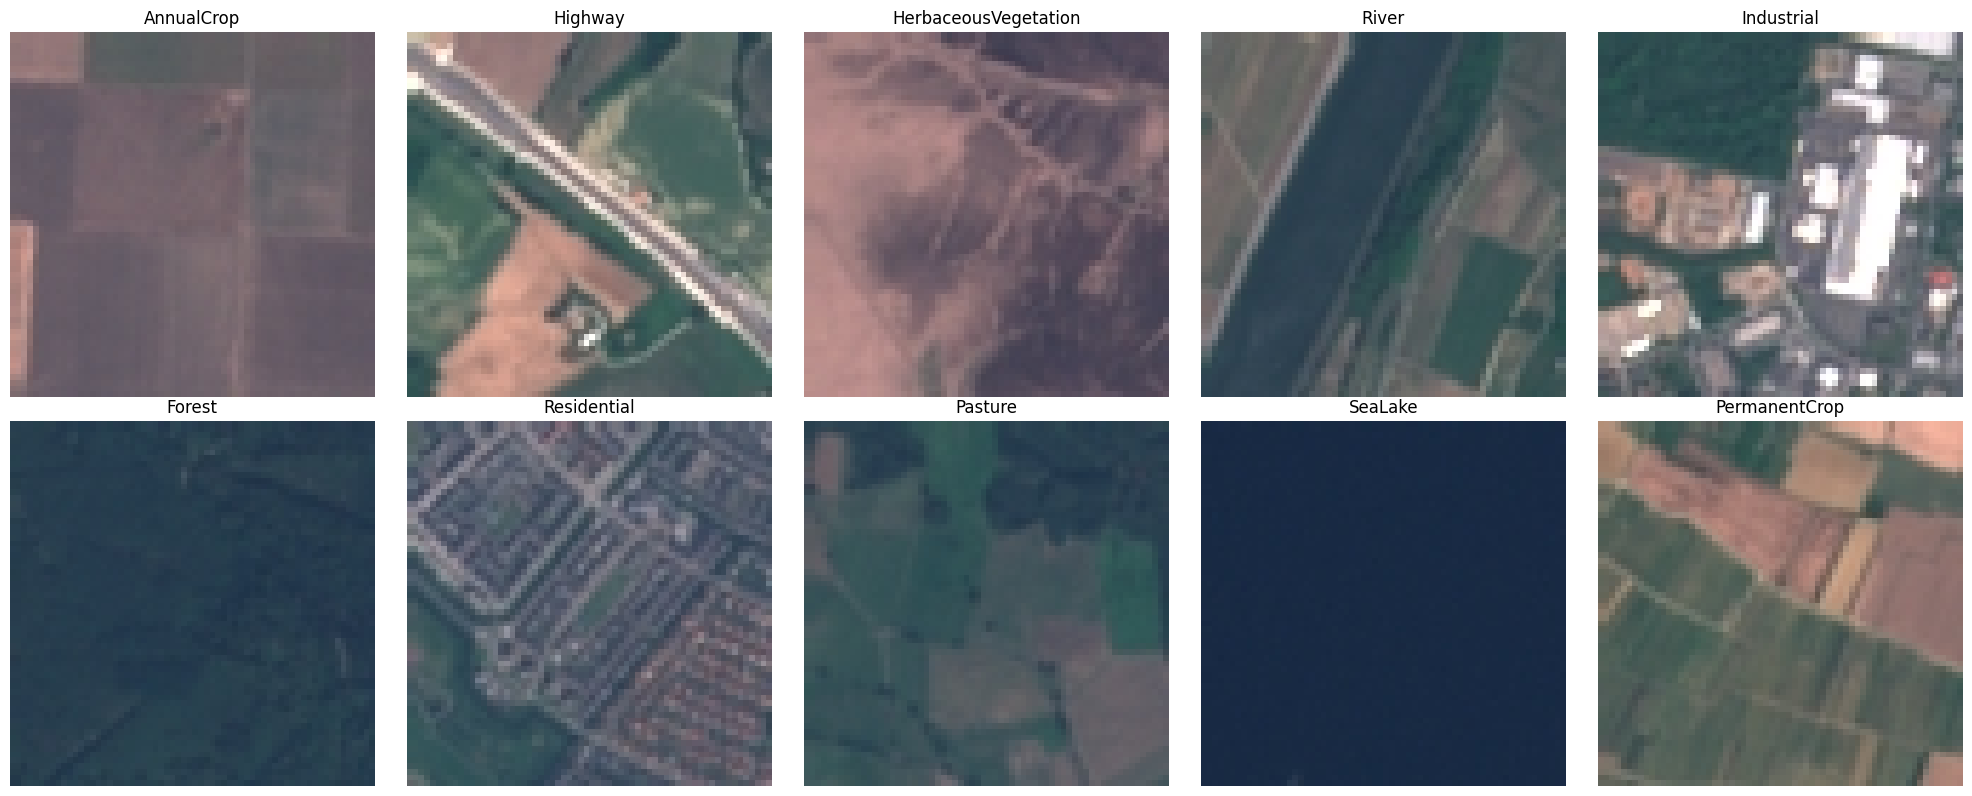

In [50]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)

    img_path = glob.glob(os.path.join(class_path, "*.jpg"))
    img_path.sort()

    img = cv2.imread(img_path[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

<h1>Histogramele de culoare</h1>
-> pentru prima si a doua imagine din fiecare clasa

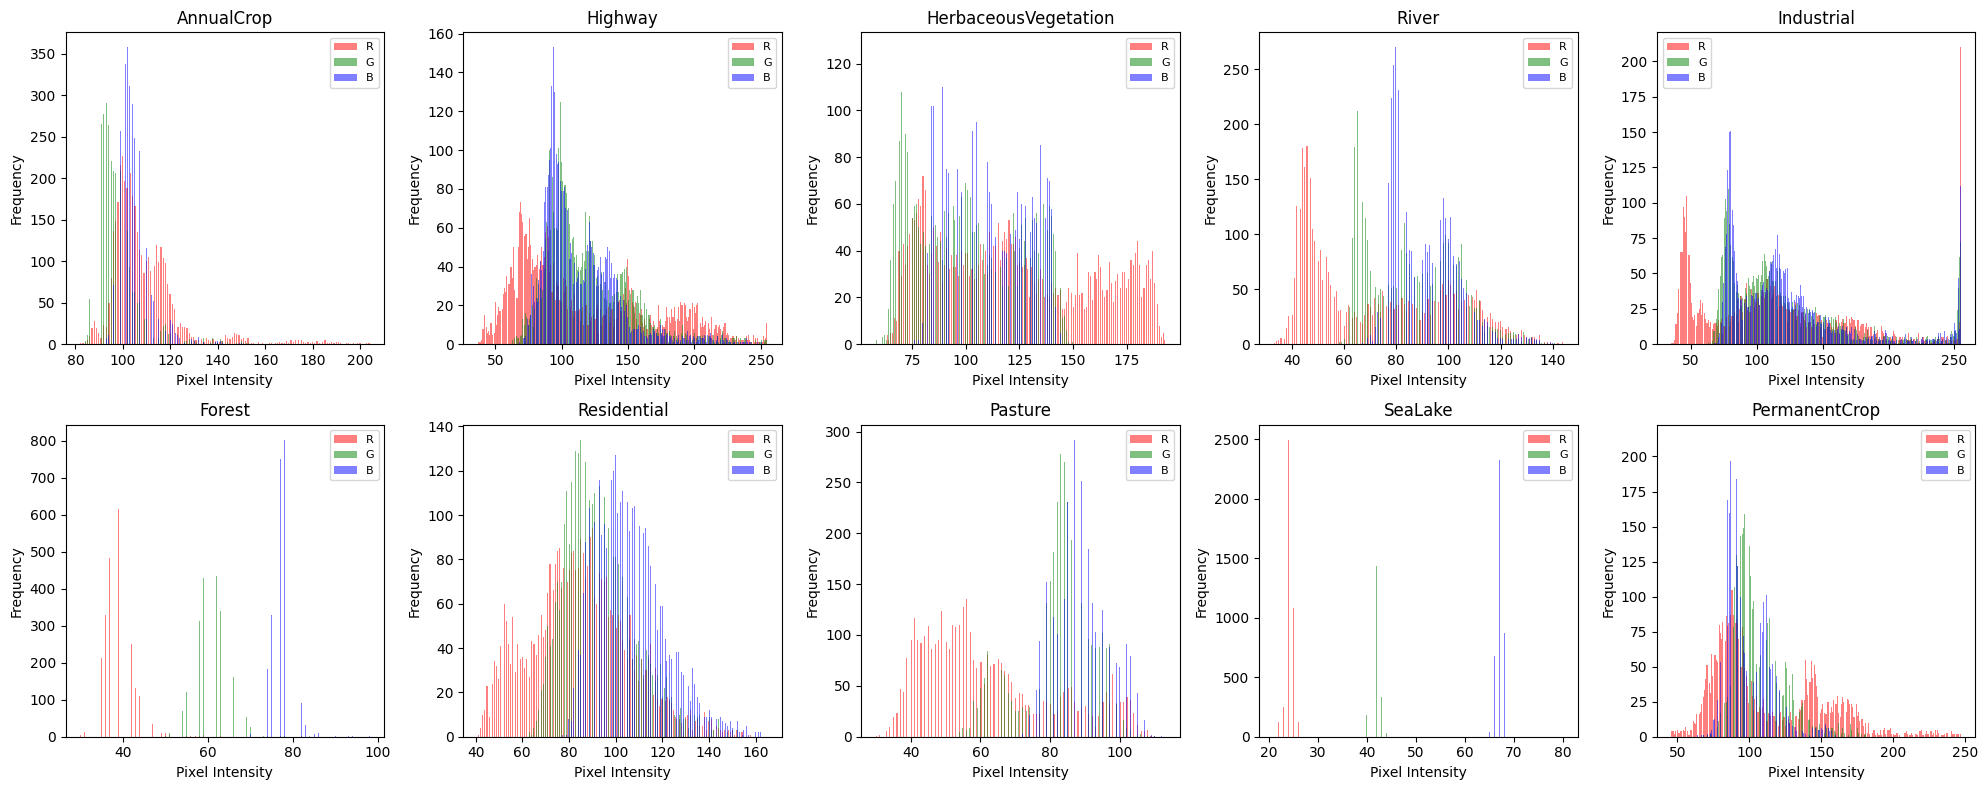

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)

    img_path = glob.glob(os.path.join(class_path, "*.jpg"))
    img_path.sort()

    img = cv2.imread(img_path[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[idx]
    colors = ('r', 'g', 'b')

    for i, color in enumerate(colors):
        ax.hist(
            img[:, :, i].ravel(),
            bins=256,
            color=color,
            alpha=0.5,
            label=color.upper()
        )

    ax.set_title(class_name)
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


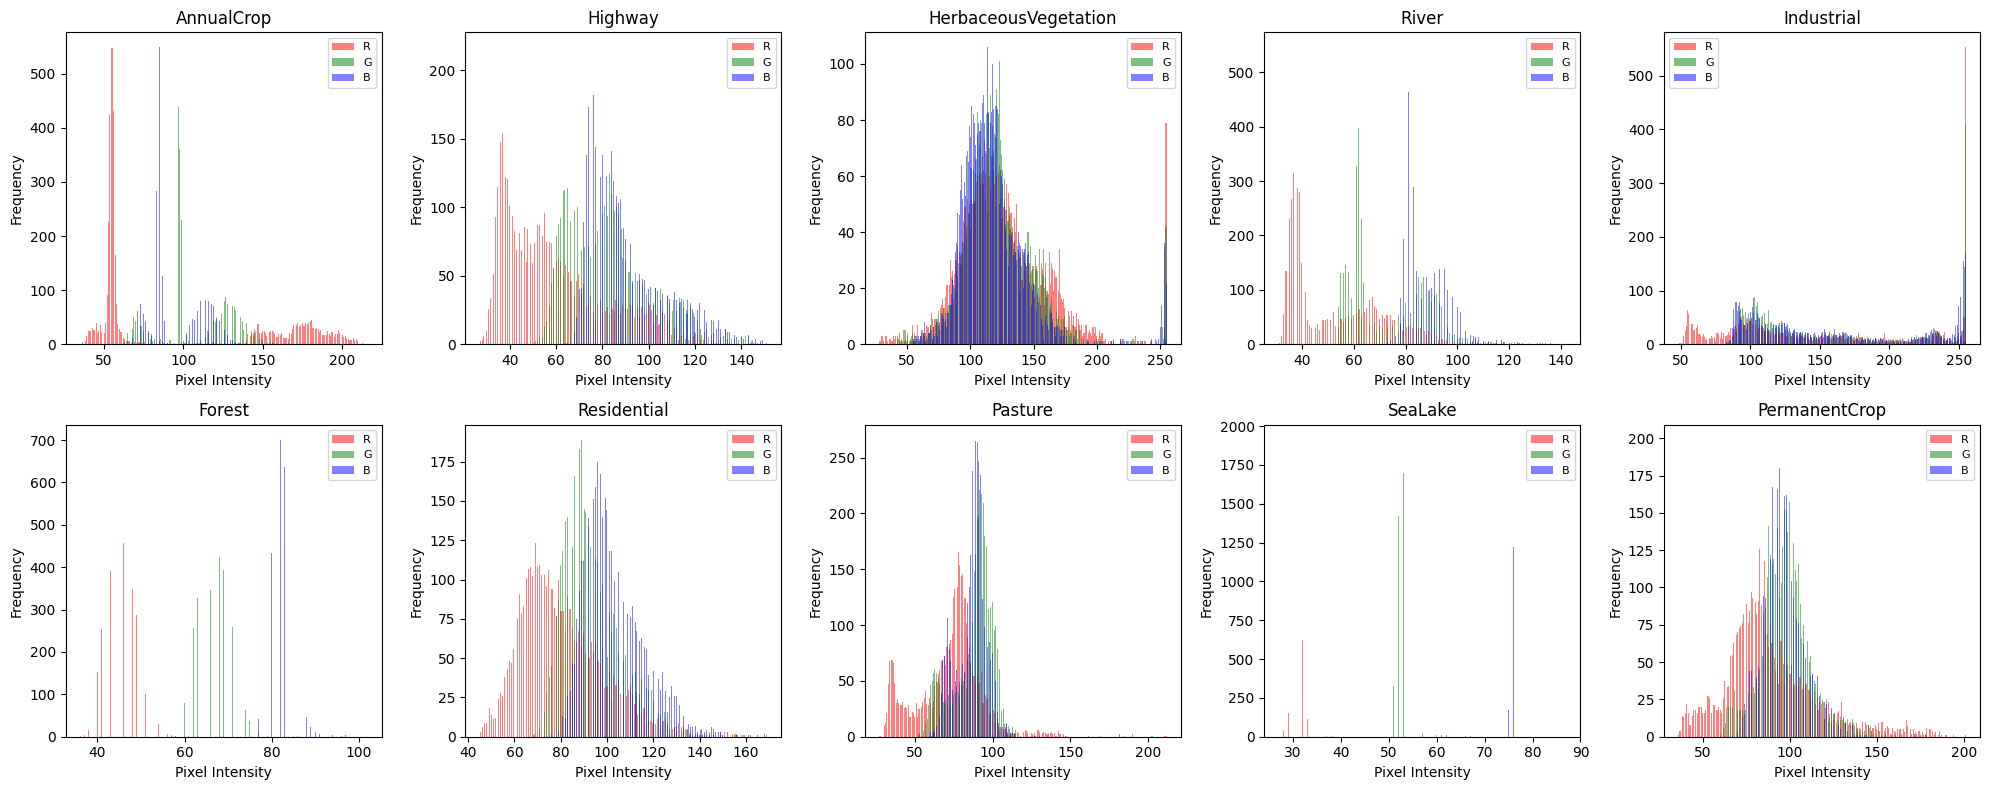

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)

    img_path = glob.glob(os.path.join(class_path, "*.jpg"))
    img_path.sort()

    img = cv2.imread(img_path[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[idx]
    colors = ('r', 'g', 'b')

    for i, color in enumerate(colors):
        ax.hist(
            img[:, :, i].ravel(),
            bins=256,
            color=color,
            alpha=0.5,
            label=color.upper()
        )

    ax.set_title(class_name)
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

<h1> Analiza PDF </h1>
-> pentru prima imagine din fiecare clasa

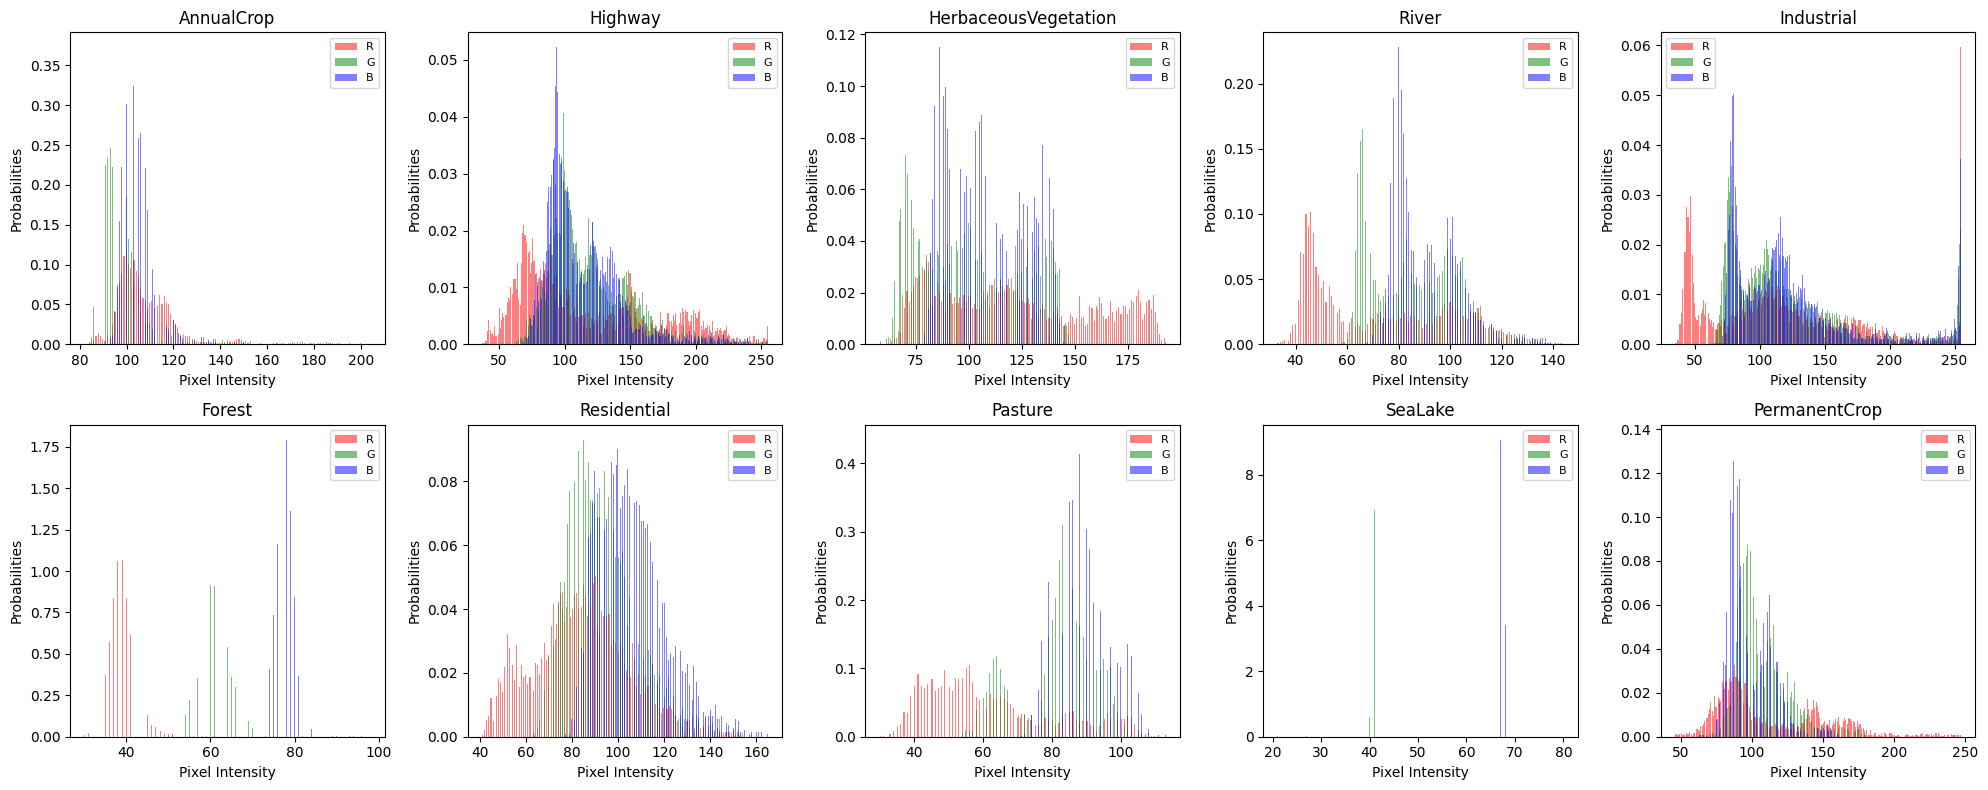

In [53]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)

    img_path = glob.glob(os.path.join(class_path, "*.jpg"))
    img_path.sort()

    img = cv2.imread(img_path[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[idx]
    colors = ('r', 'g', 'b')

    for i, color in enumerate(colors):
        ax.hist(
            img[:, :, i].ravel(),
            bins=256,
            color=color,
            density = True,
            alpha=0.5,
            label=color.upper()
        )

    ax.set_title(class_name)
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Probabilities")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


<h1> Analiza Covariantei </h1>
-> per clasa

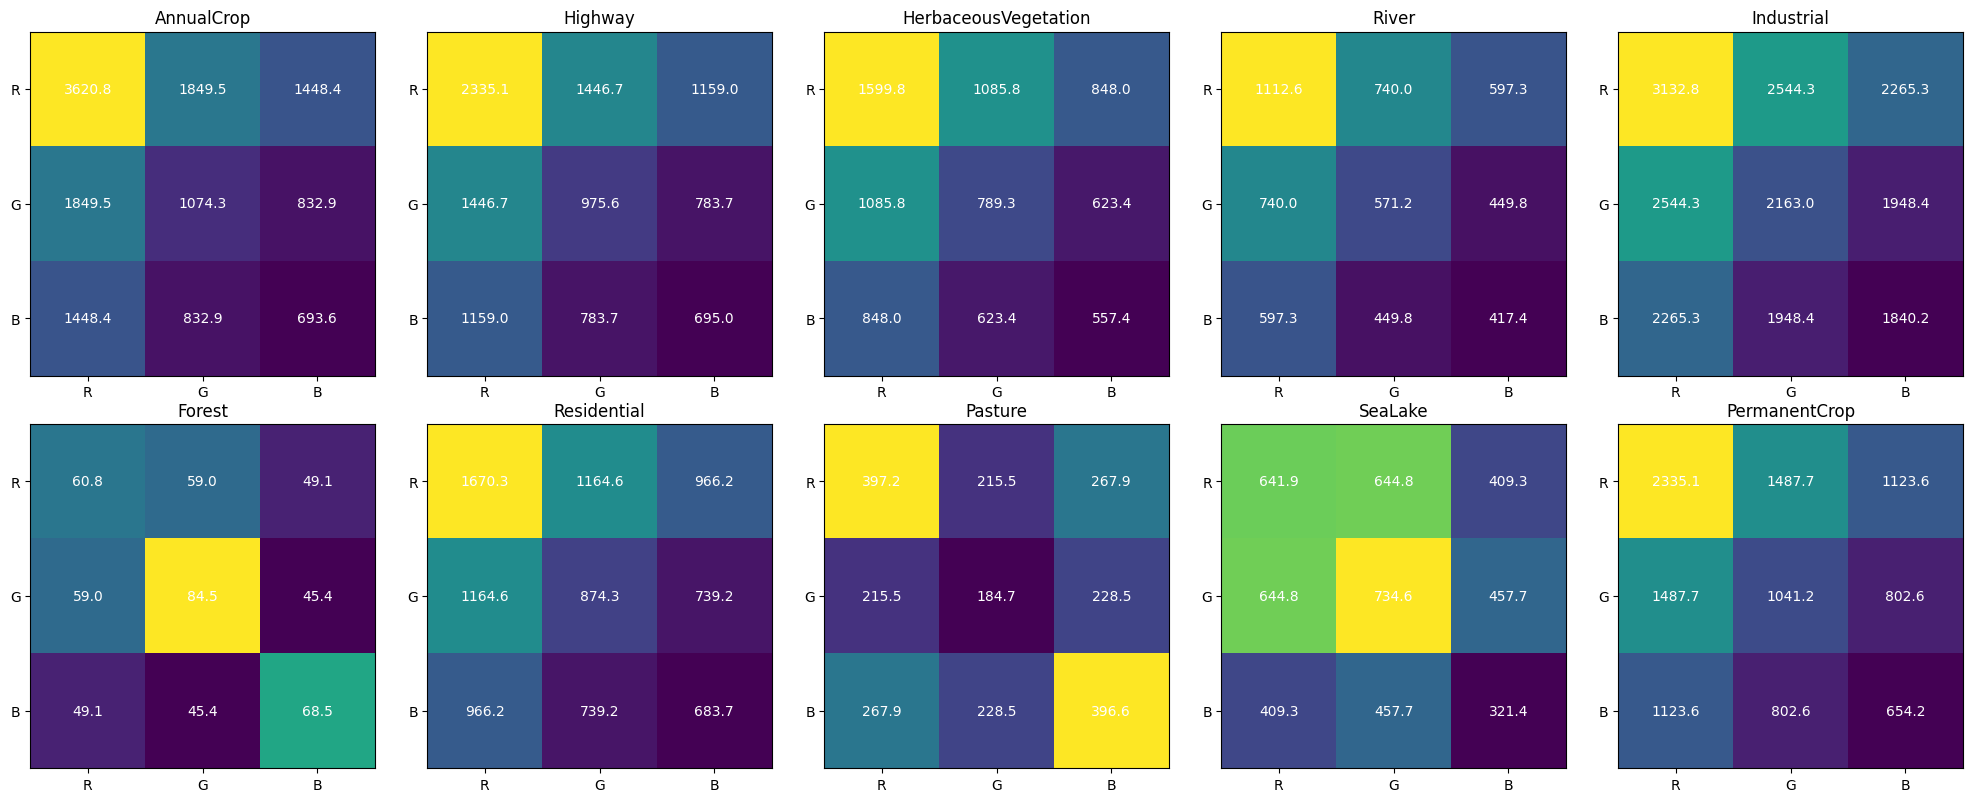

In [54]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)

    image_paths = glob.glob(os.path.join(class_path, "*.jpg"))
    image_paths.sort()

    all_pixels = []

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        pixels = img.reshape(-1, 3).astype(np.float32)
        all_pixels.append(pixels)

    # calculam covarianta dintre pixeli
    all_pixels = np.vstack(all_pixels)
    cov = np.cov(all_pixels, rowvar=False)

    ax = axes[idx]
    im = ax.imshow(cov, cmap="viridis")
    ax.set_title(class_name)

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(["R", "G", "B"])
    ax.set_yticklabels(["R", "G", "B"])


    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{cov[i, j]:.1f}",
                    ha="center", va="center",
                    color="white", fontsize=10)

plt.tight_layout()
plt.show()


<h1>Extragerea trasaturilor cu metoda Bag of visual words</h1>

In [17]:
# Load dataset
X,y = [],[]
for idx, class_name in enumerate(classes):
  class_path = os.path.join(path, class_name)
  img_paths = glob.glob(os.path.join(class_path, '*.jpg'))
  img_paths.sort()

  for image in img_paths:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    X.append(img)
    y.append(idx)

# Bag of visual words on training dataset

# # 1. Extract SIFT descriptors
# def extract_descriptors(images):
#   descriptors_list=[]
#   img_descriptors=[]

#   extractor = cv2.SIFT_create(nfeatures=2000)

#   for img in images:
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     kps, desc = extractor.detectAndCompute(gray, None)
#     if desc is None or len(desc)==0:
#       img_descriptors.append(None)
#       continue
#     desc=desc.astype(np.float32)
#     img_descriptors.append(desc)
#     descriptors_list.append(desc)

#   if len(descriptors_list)==0:
#     raise RuntimeError("No descriptors extracted. Check images.")
#   all_descriptors = np.vstack(descriptors_list)

#   return img_descriptors, all_descriptors

# 1.1. Extract LBP descriptors
def extract_descriptors(images, P=16, R=1, method="uniform", patch_size=8, stride=4, hist_bins=None):
  descriptors_list = []
  img_descriptors = []

  if hist_bins is None:
    hist_bins = P + 2 if method == "uniform" else (2 ** P)

  for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method=method).astype(np.int32)
    H, W = lbp.shape

    patches_desc = []
    for yy in range(0, H - patch_size + 1, stride):
      for xx in range(0, W - patch_size + 1, stride):
        patch = lbp[yy:yy+patch_size, xx:xx+patch_size]

        hist, _ = np.histogram(
          patch.ravel(),
          bins=np.arange(hist_bins + 1),
          range=(0, hist_bins)
        )
        hist = hist.astype(np.float32)
        s = hist.sum()
        if s > 0:
          hist /= s
        patches_desc.append(hist)

    if len(patches_desc) == 0:
      img_descriptors.append(None)
      continue

    desc = np.vstack(patches_desc).astype(np.float32)
    img_descriptors.append(desc)
    descriptors_list.append(desc)

  if len(descriptors_list)==0:
    raise RuntimeError("No descriptors extracted. Check images.")
  all_descriptors = np.vstack(descriptors_list)

  return img_descriptors, all_descriptors


# 2. Build the codebook
def build_codebook(all_descriptors, k=200):
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(all_descriptors)
  return kmeans

# 3. Histogram of codewords
def image_to_bow_hist(desc, kmeans, k):
  hist = np.zeros(k, dtype=np.float32)
  if desc is None:
    return hist
  words = kmeans.predict(desc)
  for w in words:
    hist[w] += 1.0

  # L1 normalize
  s=hist.sum()
  if s> 0:
    hist /=s

  return hist


# 4. Stack bovw features
def bovw_features(img_descriptors, kmeans, k):
  X_bovw = np.vstack([image_to_bow_hist(d, kmeans, k) for d in img_descriptors])
  return X_bovw


# 5. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_descriptors, train_all_descriptors = extract_descriptors(X_train)
test_descriptors, _ = extract_descriptors(X_test)

In [18]:
k=200
kmeans = build_codebook(train_all_descriptors, k=k)

X_train_bovw = bovw_features(train_descriptors, kmeans, k)
X_test_bovw = bovw_features(test_descriptors, kmeans, k)

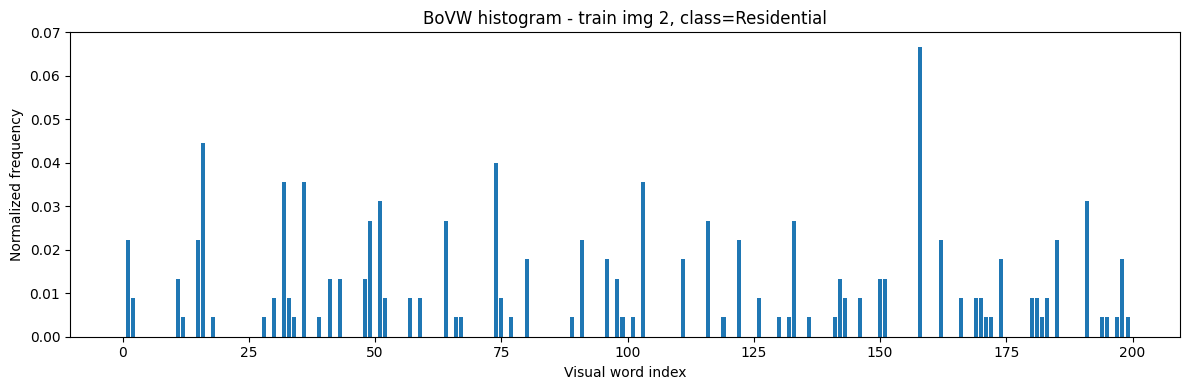

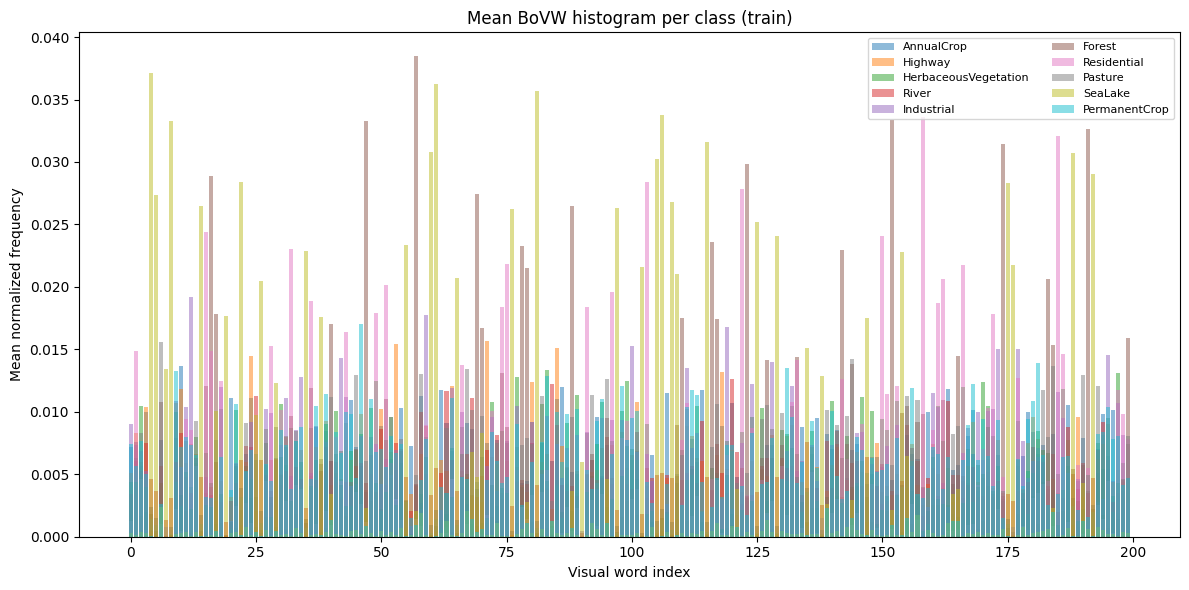

In [19]:
i = 2
plt.figure(figsize=(12,4))
plt.bar(np.arange(k), X_train_bovw[i])
plt.title(f"BoVW histogram - train img {i}, class={classes[y_train[i]]}")
plt.xlabel("Visual word index")
plt.ylabel("Normalized frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
for c in range(len(classes)):
    idxs = np.where(np.array(y_train) == c)[0]
    if len(idxs) == 0:
        continue
    mean_hist = X_train_bovw[idxs].mean(axis=0)
    plt.bar(np.arange(k), mean_hist, alpha=0.5, label=classes[c])
plt.title("Mean BoVW histogram per class (train)")
plt.xlabel("Visual word index")
plt.ylabel("Mean normalized frequency")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

In [49]:
clf = make_pipeline(
    Normalizer(norm="l2"),
    #StandardScaler(with_mean=False),

    KNeighborsClassifier(n_neighbors=15)
    #LinearSVC(C=10, class_weight="balanced", random_state=42)
    #SVC(C=2, kernel="rbf", gamma="scale", class_weight="balanced")

)
clf.fit(X_train_bovw, y_train)
predictions = clf.predict(X_test_bovw)
print("Accuracy:", accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions, target_names=classes))

Accuracy: 0.7981922154584025
[[465  43   8  34   1   0   0  35   8  26]
 [ 60 324  12  32  41   2   2   4   0  23]
 [  5   4 408   3  13  20  33  32   0  82]
 [ 60  55   8 339   3   1   0  21   3  11]
 [  0  29  15   3 423   0  10   0   0  20]
 [  0   0  13   0   0 563   1  16   7   0]
 [  0   3  25   0   9   0 560   0   0   3]
 [ 12   4  24  12   1   8   0 330   4   5]
 [  7   0   0   4   0   7   0   4 578   0]
 [ 16  30  68   6  26   1   9   7   0 337]]
                      precision    recall  f1-score   support

          AnnualCrop       0.74      0.75      0.75       620
             Highway       0.66      0.65      0.65       500
HerbaceousVegetation       0.70      0.68      0.69       600
               River       0.78      0.68      0.73       501
          Industrial       0.82      0.85      0.83       500
              Forest       0.94      0.94      0.94       600
         Residential       0.91      0.93      0.92       600
             Pasture       0.73      0.82  

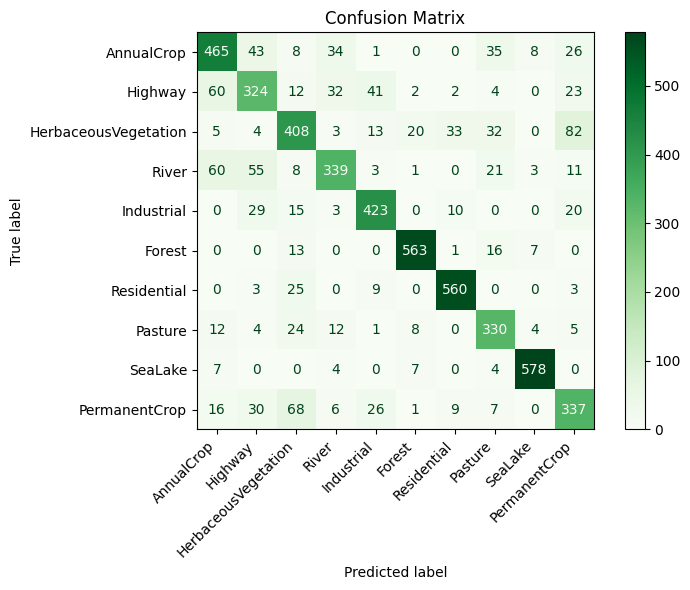

In [57]:
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, values_format="d", cmap="Greens")
ax.set_title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()